## THIS FILE CONTAINS EXPLORATORY DATA ANALYSIS FOR OGB – ogbn-products
### Basic information 
1. Dataset Overview

We used the OGB ogbn-products dataset as our main graph dataset. It consists of a very large product co-purchase graph, where each node represents an Amazon product, edges represent “frequently bought together” relationships, and node features describe product metadata.

From the loaded dataset we obtained:

Number of nodes: 2,449,029

Number of edges: 61,859,140

Node feature dimension: 100

This scale makes ogbn-products one of the largest openly available graph datasets, and its size is appropriate for studying scalable GNN methods similar to those described in the LiGNN paper. The graph is also sparse and heterogeneous, which reflects many of the challenges present in real-world recommendation systems such as LinkedIn.

In [1]:
import pandas as pd
import numpy as np
DATA_DIR = "data/raw/"

node_feat = pd.read_csv(DATA_DIR + "node-feat.csv", header=None)
node_label = pd.read_csv(DATA_DIR + "node-label.csv", header=None)
edge_index = pd.read_csv(DATA_DIR + "edge.csv", header=None)
node_feat.head(), node_label.head(), edge_index.head()
num_nodes = node_feat.shape[0]
num_edges = edge_index.shape[0]

print(f"Number of nodes: {num_nodes}")  
print(f"Number of edges: {num_edges}")
print(f"Node features shape: {node_feat.shape}")

Number of nodes: 2449029
Number of edges: 61859140
Node features shape: (2449029, 100)


### Degree distribution
This immediately gives us insight into:
- popularity
- connectivity
- usefulness of the product for learning
- how well the GNN can train on it
- how well the model will handle cold-start items

To understand the graph structure, we computed the degree of every node:

Average degree: 50.52

Median degree: 26

Minimum degree: 0

Maximum degree: 17,481

This distribution is highly skewed, which is typical for real-world interaction graphs (social networks, e-commerce, content platforms). A small number of nodes have extremely high degree, while a large number of nodes have very low degree. This “long-tail” structure confirms that the dataset resembles the behavior of networks at LinkedIn scale. 

Nodes with a very small number of neighbors (degree 0 or degree 1) are cold-start items.
These represent new or rarely purchased products for which the GNN has limited information.

Cold-start is an important concept because GNNs rely heavily on neighbors to generate good embeddings. Nodes with no or very few neighbors typically have weaker representations and lower model accuracy.

This is exactly the same challenge described in the LiGNN paper, where LinkedIn must handle many new or inactive users with extremely sparse interaction histories. Our dataset exhibits the same property, making it suitable for testing methods such as graph densification or PPR sampling.

#### High-Degree Hubs

The maximum degree of 17,481 indicates the presence of hub nodes—products that co-occur with many other items.
These hubs play an important role in the graph structure:

They carry a lot of information

They dominate message passing in GNNs

They accelerate convergence

But they can cause over-smoothing or over-representation if not sampled properly

This is another similarity with LinkedIn’s large graph, where extremely active users or highly popular companies form dense subgraphs that require specialized neighbor sampling strategies.

In [2]:
import numpy as np

# count degrees
degrees = np.zeros(num_nodes, dtype=int)

for src, dst in edge_index.values:
    degrees[src] += 1
    degrees[dst] += 1

print("Average degree:", degrees.mean())
print("Median degree:", np.median(degrees))
print("Min degree:", degrees.min())
print("Max degree:", degrees.max())


Average degree: 50.517278480573324
Median degree: 26.0
Min degree: 0
Max degree: 17481


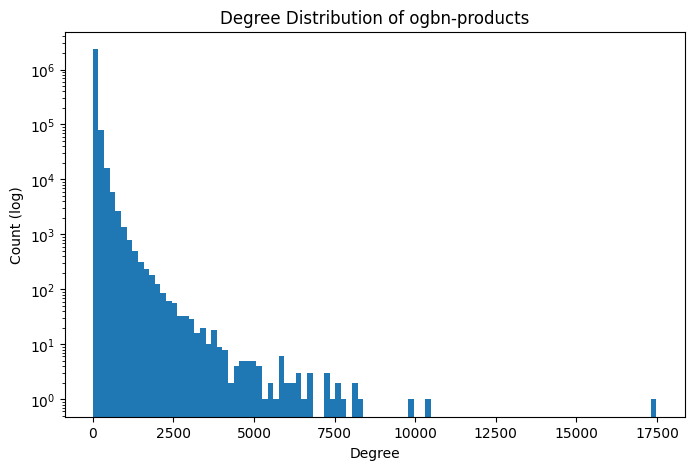

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=100)
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Count (log)")
plt.title("Degree Distribution of ogbn-products")
plt.show()


In [4]:
cold_start_nodes = np.sum(degrees <= 1)
print("Cold-start nodes (degree ≤ 1):", cold_start_nodes)
print("Percentage:", cold_start_nodes / num_nodes * 100, "%")


Cold-start nodes (degree ≤ 1): 151412
Percentage: 6.1825319340848965 %


### Connected components
how many “separated islands” the graph contains.
- Large number of components = sparse graph
- Similar to LinkedIn’s multi-domain graph (users, posts, jobs, etc.)


The ogbn-products graph contains a significant number of connected components, meaning the graph is composed of many isolated or weakly linked subgraphs. This structure reflects the natural sparsity of large-scale interaction networks, where many items or entities have very limited connections. In practice, this results in cold-start situations for low-degree nodes and reinforces the necessity for scalable neighbor sampling and densification strategies. The presence of many small components also mirrors LinkedIn’s multi-domain graph described in the LiGNN paper, where entities (users, posts, companies, skills) are organized into heterogeneous clusters that are not fully interconnected. This validates the dataset’s suitability for studying LiGNN-inspired GNN architectures.

In [5]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edge_index.values)

components = nx.number_connected_components(G)
print("Connected components:", components)


Connected components: 52658
